In [1]:
import numpy as np
import os
import xarray as xr
import re  # Import the regular expression module
import matplotlib.pyplot as plt

# Load tide gauges data

In [2]:


# Path to the saved dataset
output_file = '/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_time_series_tidegauges/tide_gauge_data.npz'

# Load the .npz file
with np.load(output_file) as data:
    # Extract the arrays
    filtered_sla_dac_demeaned = data['filtered_sla_dac_demeaned']  # Shape: (time, n_gauges)
    filtered_sla_dac_filtered = data['filtered_sla_dac_filtered']  # Shape: (time, n_gauges)
    valid_site_names = data['valid_site_names']  # Array of site names
    valid_latitudes = data['valid_latitudes']  # Array of latitudes
    valid_longitudes = data['valid_longitudes']  # Array of longitudes

# Print the shapes and metadata to understand the structure
print("Shape of filtered_sla_dac_demeaned:", filtered_sla_dac_demeaned.shape)
print("Shape of filtered_sla_dac_filtered:", filtered_sla_dac_filtered.shape)
print("Number of tide gauge sites:", len(valid_site_names))
print("Latitude range:", valid_latitudes.min(), "to", valid_latitudes.max())
print("Longitude range:", valid_longitudes.min(), "to", valid_longitudes.max())

# Optionally, print the first few site names for verification
print("First few tide gauge site names:", valid_site_names[:5])



# Load corresponding locations of altimetry and model

# Do the correlation analysis already made in analyse_tg_ctw_withswot

# (Here or in another code) Do the Hovmöller plot analysis and the computation of the wave
# speed

Shape of filtered_sla_dac_demeaned: (94, 5)
Shape of filtered_sla_dac_filtered: (94, 5)
Number of tide gauge sites: 5
Latitude range: -36.42633887 to -28.53681115
Longitude range: 150.0715333 to 153.55211
First few tide gauge site names: ['Bermagui' 'Crookhaven_Heads' 'Port_Macquarie' 'Coffs_Harbour'
 'Brunswick_Heads']


# Find closest point to tide gauges of the different dataset

In [3]:


def find_closest_file_with_non_nan(cmems_dir, tide_gauge_lat, tide_gauge_lon, nan_threshold=0.9):
    """
    Search for the closest file with valid (non-NaN) SLA data.
    If more than `nan_threshold` percentage of values are NaN, skip the file.
    """
    closest_distance = float('inf')
    closest_file = None

    for file_name in os.listdir(cmems_dir):
        if file_name.startswith("filtered_sla_lat_") and file_name.endswith(".nc"):
            # Extract latitude and longitude from the filename
            match = re.search(r'lat_([-+]?\d*\.\d+)_lon_([-+]?\d*\.\d+)', file_name)
            if match:
                file_lat = float(match.group(1))
                file_lon = float(match.group(2))

                # Calculate distance to tide gauge
                distance = np.sqrt((file_lat - tide_gauge_lat)**2 + (file_lon - tide_gauge_lon)**2)

                if distance < closest_distance:
                    
                    # Open the file and check for non-NaN values
                    file_path = os.path.join(cmems_dir, file_name)
                    with xr.open_dataset(file_path) as ds:
                        unfiltered_sla = ds['unfiltered_sla'].values  # Using 'unfiltered_sla' instead of 'sla'
                        nan_percentage = np.sum(np.isnan(unfiltered_sla)) / unfiltered_sla.size

                        # If more than 90% of the values are NaN, skip this file
                        if nan_percentage < nan_threshold:
                            closest_distance = distance
                            closest_file = file_path

    return closest_file, closest_distance


def organize_data_cmems(valid_latitudes, valid_longitudes, valid_site_names, cmems_dir, dataset_type="CMEMS"):
    """
    Organize data from CMEMS, SWOT, or BLUELINK datasets into arrays matching the structure of the tide gauge data.
    """
    n_sites = len(valid_latitudes)
    n_time_steps = None
    unfiltered_sla_array = []
    filtered_sla_array = []

    for idx in range(n_sites):
        tide_gauge_lat = valid_latitudes[idx]
        tide_gauge_lon = valid_longitudes[idx]
        tide_gauge_name = valid_site_names[idx]

        print(f"Processing tide gauge: {tide_gauge_name} at ({tide_gauge_lat}, {tide_gauge_lon})")

        # Find the closest file with non-NaN data
        closest_file, closest_distance = find_closest_file_with_non_nan(cmems_dir, tide_gauge_lat, tide_gauge_lon)
        print(closest_distance)
        
        if closest_file:
            # Load the closest valid file
            with xr.open_dataset(closest_file) as ds:
                if dataset_type == "CMEMS":
                    # Assuming CMEMS has 'unfiltered_sla' and 'filtered_sla'
                    unfiltered_sla = ds['unfiltered_sla'].values
                    filtered_sla = ds['filtered_sla'].values
                elif dataset_type == "SWOT":
                    # Assuming SWOT dataset uses similar variable names but differs slightly
                    unfiltered_sla = ds['unfiltered_sla'].values
                    filtered_sla = ds['filtered_sla'].values
                elif dataset_type == "BLUELINK":
                    # Assuming BLUELINK dataset follows similar naming conventions
                    unfiltered_sla = ds['unfiltered_sla'].values
                    filtered_sla = ds['filtered_sla'].values
                
                if n_time_steps is None:
                    n_time_steps = unfiltered_sla.shape[0]  # Initialize n_time_steps based on the first file

                # Append the data for each site
                unfiltered_sla_array.append(unfiltered_sla)
                filtered_sla_array.append(filtered_sla)
        else:
            print(f"No valid file found for {tide_gauge_name} at ({tide_gauge_lat}, {tide_gauge_lon})")

    # Convert lists to numpy arrays
    unfiltered_sla_array = np.array(unfiltered_sla_array)
    filtered_sla_array = np.array(filtered_sla_array)

    # Transpose the arrays to match the desired shape (n_time_steps, n_sites)
    unfiltered_sla_array = unfiltered_sla_array.T
    filtered_sla_array = filtered_sla_array.T

    return unfiltered_sla_array, filtered_sla_array


# Example usage:
# Load the tide gauge data (valid_latitudes, valid_longitudes, valid_site_names) from the npz file
output_dir = '/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_time_series_tidegauges/'
tide_gauge_data = np.load(os.path.join(output_dir, 'tide_gauge_data.npz'))

valid_latitudes = tide_gauge_data['valid_latitudes']
valid_longitudes = tide_gauge_data['valid_longitudes']
valid_site_names = tide_gauge_data['valid_site_names']

# First run: Organize the data from CMEMS
cmems_dir = '/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_CMEMS/'
unfiltered_sla_array_cmems, filtered_sla_array_cmems = organize_data_cmems(valid_latitudes, valid_longitudes, valid_site_names, cmems_dir, dataset_type="CMEMS")

# Second run: Organize the data from SWOT
swot_dir = '/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT'
unfiltered_sla_array_ml, filtered_sla_array_ml = organize_data_cmems(valid_latitudes, valid_longitudes, valid_site_names, swot_dir, dataset_type="SWOT")

# Third run: Organize the data from BLUELINK
bluelink_dir = '/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_BLUELINK'
unfiltered_sla_array_bluelink, filtered_sla_array_bluelink = organize_data_cmems(valid_latitudes, valid_longitudes, valid_site_names, bluelink_dir, dataset_type="BLUELINK")

# Now, unfiltered_sla_array_cmems, filtered_sla_array_cmems, unfiltered_sla_array_ml, filtered_sla_array_ml,
# unfiltered_sla_array_bluelink, and filtered_sla_array_bluelink hold the data for the different datasets


Processing tide gauge: Bermagui at (-36.42633887, 150.0715333)
0.06705454407993115
Processing tide gauge: Crookhaven_Heads at (-34.9066, 150.7592)
0.12369397721797279
Processing tide gauge: Port_Macquarie at (-31.42679171, 152.9109833)
0.05611977373096169
Processing tide gauge: Coffs_Harbour at (-30.30285837, 153.1460611)
0.08142488570619238
Processing tide gauge: Brunswick_Heads at (-28.53681115, 153.55211)
0.10737521531677455
Processing tide gauge: Bermagui at (-36.42633887, 150.0715333)
0.03878258735266175
Processing tide gauge: Crookhaven_Heads at (-34.9066, 150.7592)
0.04133037623832503
Processing tide gauge: Port_Macquarie at (-31.42679171, 152.9109833)
0.09296111339487341
Processing tide gauge: Coffs_Harbour at (-30.30285837, 153.1460611)
0.0540145833295599
Processing tide gauge: Brunswick_Heads at (-28.53681115, 153.55211)
0.0604029209916369
Processing tide gauge: Bermagui at (-36.42633887, 150.0715333)
0.08195652555939661
Processing tide gauge: Crookhaven_Heads at (-34.9066, 1

# Plot examples of filtered and unfiltered time series

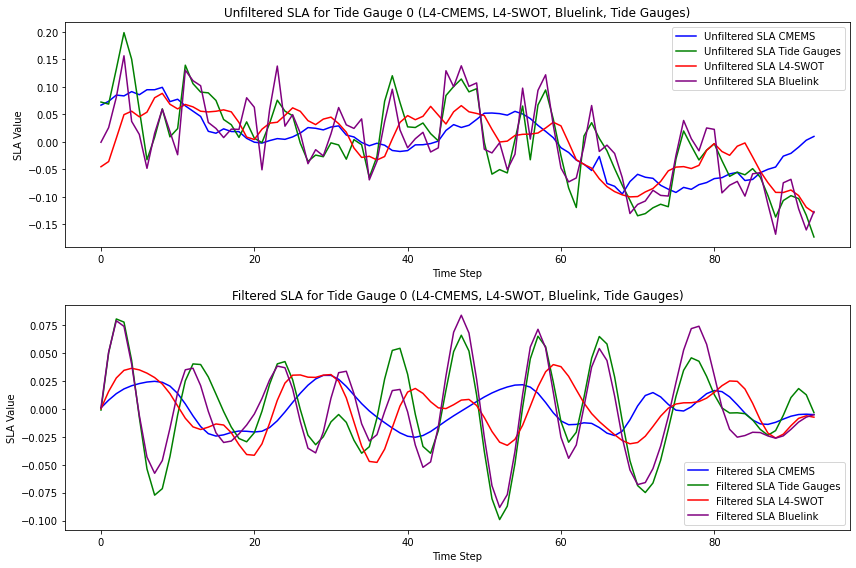

Correlations for Filtered Time Series (Tide Gauge 0):
CMEMS vs Tide Gauges: -0.24634392778156095
SWOT vs Tide Gauges: 0.25720528227637945
Bluelink vs Tide Gauges: 0.8965128128755164
Correlations for Unfiltered Time Series (Tide Gauge 0):
CMEMS vs Tide Gauges: 0.5585645792288682
SWOT vs Tide Gauges: 0.7067268520463845
Bluelink vs Tide Gauges: 0.8976414984909993


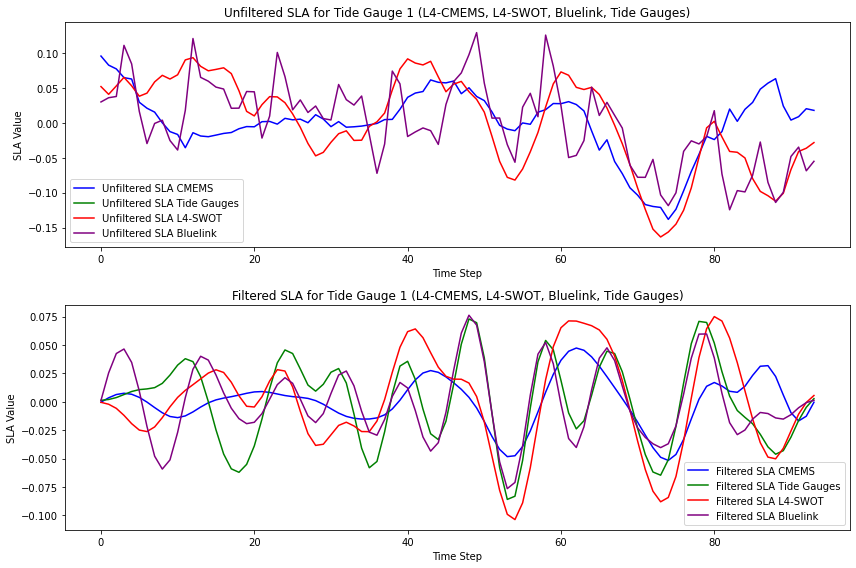

Correlations for Filtered Time Series (Tide Gauge 1):
CMEMS vs Tide Gauges: 0.29677481278492307
SWOT vs Tide Gauges: 0.5384397430400787
Bluelink vs Tide Gauges: 0.7419623684768547
Correlations for Unfiltered Time Series (Tide Gauge 1):
CMEMS vs Tide Gauges: nan
SWOT vs Tide Gauges: nan
Bluelink vs Tide Gauges: nan


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value enc

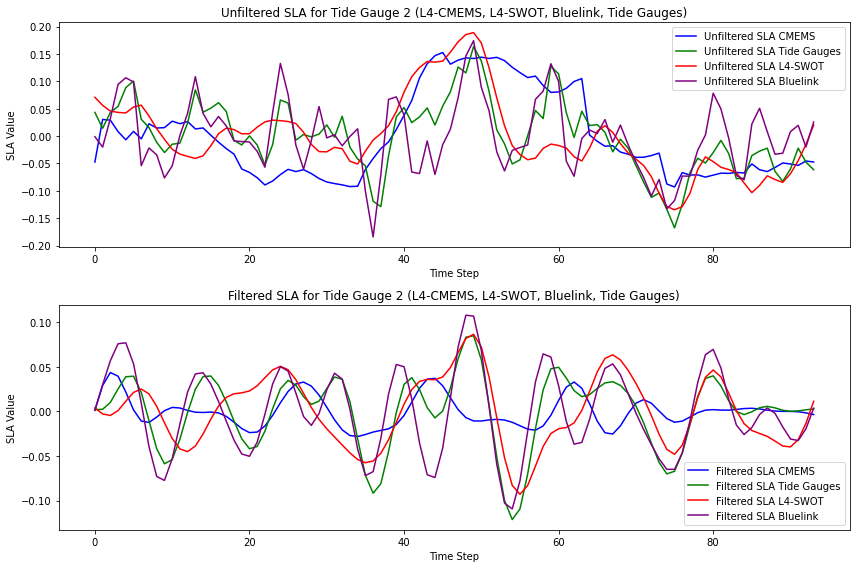

Correlations for Filtered Time Series (Tide Gauge 2):
CMEMS vs Tide Gauges: 0.32981198483179636
SWOT vs Tide Gauges: 0.6319919439176727
Bluelink vs Tide Gauges: 0.8177602896874345
Correlations for Unfiltered Time Series (Tide Gauge 2):
CMEMS vs Tide Gauges: 0.5708031892187132
SWOT vs Tide Gauges: 0.6976675441270661
Bluelink vs Tide Gauges: 0.7498463039989768


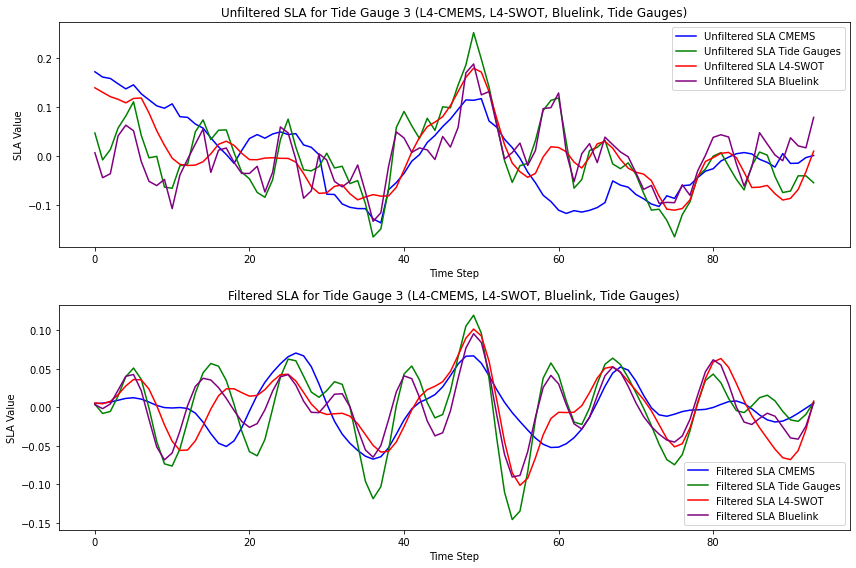

Correlations for Filtered Time Series (Tide Gauge 3):
CMEMS vs Tide Gauges: 0.43162370672184114
SWOT vs Tide Gauges: 0.7009006505659952
Bluelink vs Tide Gauges: 0.919403373097855
Correlations for Unfiltered Time Series (Tide Gauge 3):
CMEMS vs Tide Gauges: 0.4695990874362881
SWOT vs Tide Gauges: 0.7531195762743093
Bluelink vs Tide Gauges: 0.8333029362403374


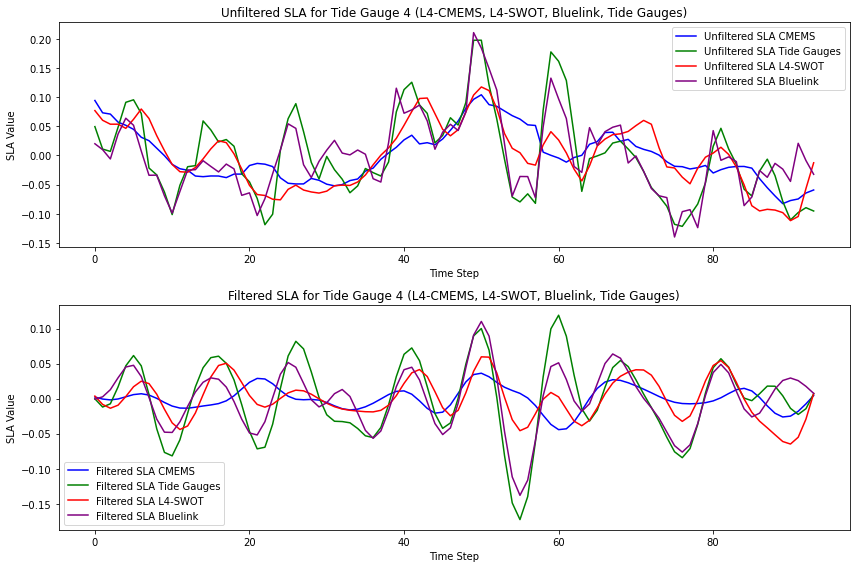

Correlations for Filtered Time Series (Tide Gauge 4):
CMEMS vs Tide Gauges: -0.0007490700399924599
SWOT vs Tide Gauges: 0.5934881937842216
Bluelink vs Tide Gauges: 0.8980042963791159
Correlations for Unfiltered Time Series (Tide Gauge 4):
CMEMS vs Tide Gauges: 0.45349368424307895
SWOT vs Tide Gauges: 0.6429147488393989
Bluelink vs Tide Gauges: 0.8617090979034405


In [4]:
# Define a function to compute correlation while handling NaNs
def compute_correlation(arr1, arr2):
    # Mask NaNs in both arrays
    mask = ~np.isnan(arr1) & ~np.isnan(arr2)
    return np.corrcoef(arr1[mask], arr2[mask])[0, 1]

# Assuming these arrays are already defined and loaded:
# filtered_sla_array_cmems, filtered_sla_dac_filtered, filtered_sla_array_ml, 
# unfiltered_sla_array_cmems, filtered_sla_dac_demeaned, unfiltered_sla_array_ml,
# filtered_sla_array_bluelink, unfiltered_sla_array_bluelink,
# filtered_sla_dac_filtered_bluelink, filtered_sla_dac_demeaned_bluelink

for select_tg in range(5):  # Loop through each tide gauge (0 to 4)
    # Remove the mean from each time series for the selected tide gauge (demean)
    unfiltered_sla_array_cmems_demeaned = unfiltered_sla_array_cmems[:, select_tg] - np.mean(unfiltered_sla_array_cmems[:, select_tg])
    unfiltered_sla_array_ml_demeaned = unfiltered_sla_array_ml[:, select_tg] - np.mean(unfiltered_sla_array_ml[:, select_tg])
    unfiltered_sla_array_bluelink_demeaned = unfiltered_sla_array_bluelink[:, select_tg] - np.mean(unfiltered_sla_array_bluelink[:, select_tg])
    filtered_sla_array_cmems_demeaned = filtered_sla_array_cmems[:, select_tg] - np.mean(filtered_sla_array_cmems[:, select_tg])
    filtered_sla_array_ml_demeaned = filtered_sla_array_ml[:, select_tg] - np.mean(filtered_sla_array_ml[:, select_tg])
    filtered_sla_array_bluelink_demeaned = filtered_sla_array_bluelink[:, select_tg] - np.mean(filtered_sla_array_bluelink[:, select_tg])
    filtered_sla_dac_filtered_demeaned = filtered_sla_dac_filtered[:, select_tg] - np.mean(filtered_sla_dac_filtered[:, select_tg])
    filtered_sla_dac_demeaned_bluelink_demeaned = filtered_sla_dac_demeaned[:, select_tg] - np.mean(filtered_sla_dac_demeaned[:, select_tg])

    # Plot the unfiltered time series for all datasets (CMEMS, SWOT, Bluelink, and Tide Gauges)
    plt.figure(figsize=(12, 8))
    
    # Unfiltered plot (CMEMS, SWOT, Bluelink, and Tide Gauges)
    plt.subplot(2, 1, 1)
    plt.plot(unfiltered_sla_array_cmems_demeaned, label='Unfiltered SLA CMEMS', color='b')
    plt.plot(filtered_sla_dac_demeaned_bluelink_demeaned, label='Unfiltered SLA Tide Gauges', color='g')
    plt.plot(unfiltered_sla_array_ml_demeaned, label='Unfiltered SLA L4-SWOT', color='r')
    plt.plot(unfiltered_sla_array_bluelink_demeaned, label='Unfiltered SLA Bluelink', color='purple')
    plt.legend()
    plt.xlabel('Time Step')
    plt.ylabel('SLA Value')
    plt.title(f'Unfiltered SLA for Tide Gauge {select_tg} (L4-CMEMS, L4-SWOT, Bluelink, Tide Gauges)')
    
    # Filtered plot (CMEMS, SWOT, Bluelink, and Tide Gauges)
    plt.subplot(2, 1, 2)
    plt.plot(filtered_sla_array_cmems_demeaned, label='Filtered SLA CMEMS', color='b')
    plt.plot(filtered_sla_dac_filtered_demeaned, label='Filtered SLA Tide Gauges', color='g')
    plt.plot(filtered_sla_array_ml_demeaned, label='Filtered SLA L4-SWOT', color='r')
    plt.plot(filtered_sla_array_bluelink_demeaned, label='Filtered SLA Bluelink', color='purple')
    plt.legend()
    plt.xlabel('Time Step')
    plt.ylabel('SLA Value')
    plt.title(f'Filtered SLA for Tide Gauge {select_tg} (L4-CMEMS, L4-SWOT, Bluelink, Tide Gauges)')
    
    # Display both plots
    plt.tight_layout()
    plt.show()

    # Compute and print correlations for filtered signals
    print(f"Correlations for Filtered Time Series (Tide Gauge {select_tg}):")
    print(f"CMEMS vs Tide Gauges: {compute_correlation(filtered_sla_array_cmems_demeaned, filtered_sla_dac_filtered_demeaned)}")
    print(f"SWOT vs Tide Gauges: {compute_correlation(filtered_sla_array_ml_demeaned, filtered_sla_dac_filtered_demeaned)}")
    print(f"Bluelink vs Tide Gauges: {compute_correlation(filtered_sla_array_bluelink_demeaned, filtered_sla_dac_filtered_demeaned)}")
    
    # Compute and print correlations for unfiltered signals
    print(f"Correlations for Unfiltered Time Series (Tide Gauge {select_tg}):")
    print(f"CMEMS vs Tide Gauges: {compute_correlation(unfiltered_sla_array_cmems_demeaned, filtered_sla_dac_demeaned_bluelink_demeaned)}")
    print(f"SWOT vs Tide Gauges: {compute_correlation(unfiltered_sla_array_ml_demeaned, filtered_sla_dac_demeaned_bluelink_demeaned)}")
    print(f"Bluelink vs Tide Gauges: {compute_correlation(unfiltered_sla_array_bluelink_demeaned, filtered_sla_dac_demeaned_bluelink_demeaned)}")


# Plot correlation statistics at closest points

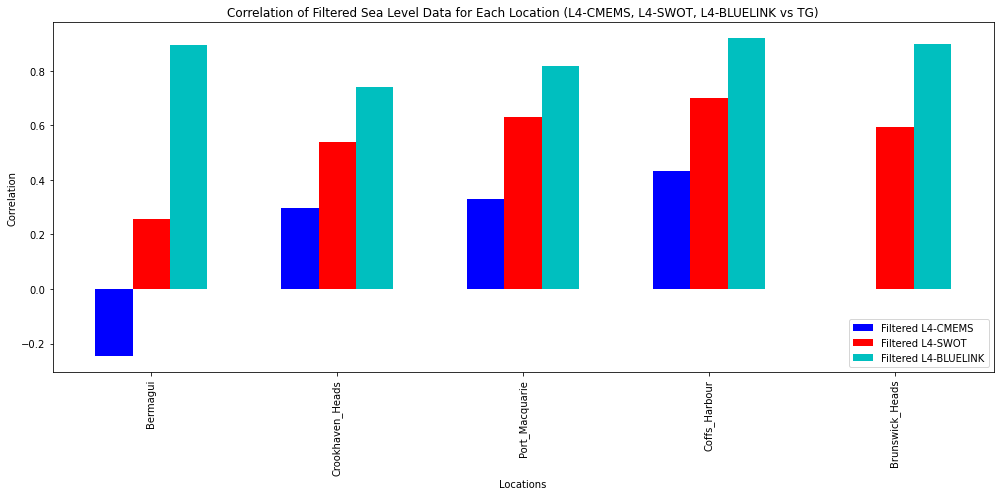

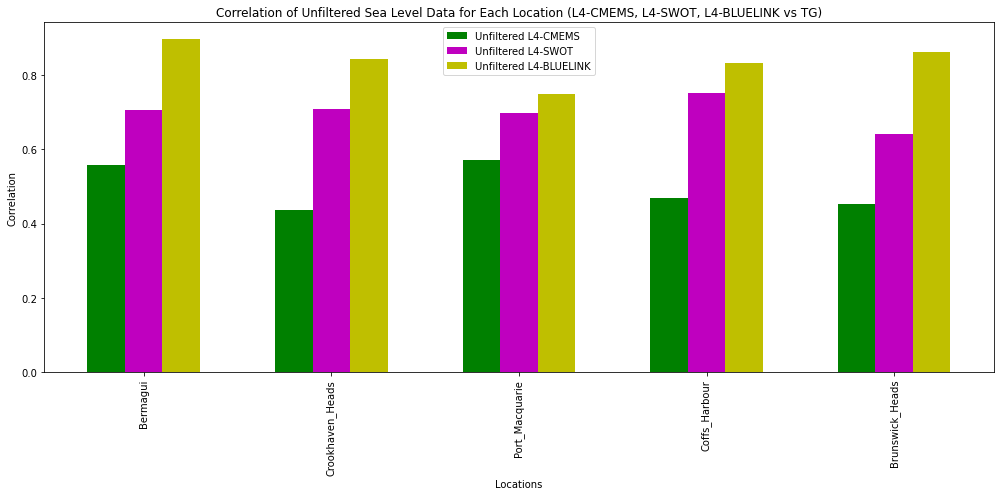

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming filtered_sla_array_cmems, filtered_sla_dac_filtered, unfiltered_sla_array_cmems,
# filtered_sla_dac_demeaned, filtered_sla_array_ml, unfiltered_sla_array_ml,
# filtered_sla_array_bluelink, unfiltered_sla_array_bluelink are already defined

# Locations
locations = valid_site_names

# Calculate correlation for filtered CMEMS data
filtered_correlations_cmems = []
for i in range(filtered_sla_array_cmems.shape[1]):
    corr = np.corrcoef(filtered_sla_array_cmems[:, i], filtered_sla_dac_filtered[:, i])[0, 1]
    filtered_correlations_cmems.append(corr)

# Calculate correlation for unfiltered CMEMS data
unfiltered_correlations_cmems = []
for i in range(unfiltered_sla_array_cmems.shape[1]):
    # Handle NaNs in unfiltered_sla_array_cmems and filtered_sla_dac_demeaned
    valid_indices = ~np.isnan(unfiltered_sla_array_cmems[:, i]) & ~np.isnan(filtered_sla_dac_demeaned[:, i])
    if np.any(valid_indices):
        corr = np.corrcoef(unfiltered_sla_array_cmems[valid_indices, i], filtered_sla_dac_demeaned[valid_indices, i])[0, 1]
    else:
        corr = np.nan  # If no valid data points, correlation is NaN
    unfiltered_correlations_cmems.append(corr)

# Calculate correlation for filtered ML data
filtered_correlations_ml = []
for i in range(filtered_sla_array_ml.shape[1]):
    corr = np.corrcoef(filtered_sla_array_ml[:, i], filtered_sla_dac_filtered[:, i])[0, 1]
    filtered_correlations_ml.append(corr)

# Calculate correlation for unfiltered ML data
unfiltered_correlations_ml = []
for i in range(unfiltered_sla_array_ml.shape[1]):
    # Handle NaNs in unfiltered_sla_array_ml and filtered_sla_dac_demeaned
    valid_indices = ~np.isnan(unfiltered_sla_array_ml[:, i]) & ~np.isnan(filtered_sla_dac_demeaned[:, i])
    if np.any(valid_indices):
        corr = np.corrcoef(unfiltered_sla_array_ml[valid_indices, i], filtered_sla_dac_demeaned[valid_indices, i])[0, 1]
    else:
        corr = np.nan  # If no valid data points, correlation is NaN
    unfiltered_correlations_ml.append(corr)

# Calculate correlation for filtered BLUELINK data
filtered_correlations_bluelink = []
for i in range(filtered_sla_array_bluelink.shape[1]):
    corr = np.corrcoef(filtered_sla_array_bluelink[:, i], filtered_sla_dac_filtered[:, i])[0, 1]
    filtered_correlations_bluelink.append(corr)

# Calculate correlation for unfiltered BLUELINK data
unfiltered_correlations_bluelink = []
for i in range(unfiltered_sla_array_bluelink.shape[1]):
    # Handle NaNs in unfiltered_sla_array_bluelink and filtered_sla_dac_demeaned
    valid_indices = ~np.isnan(unfiltered_sla_array_bluelink[:, i]) & ~np.isnan(filtered_sla_dac_demeaned[:, i])
    if np.any(valid_indices):
        corr = np.corrcoef(unfiltered_sla_array_bluelink[valid_indices, i], filtered_sla_dac_demeaned[valid_indices, i])[0, 1]
    else:
        corr = np.nan  # If no valid data points, correlation is NaN
    unfiltered_correlations_bluelink.append(corr)

# Plotting filtered correlations
plt.figure(figsize=(14, 7))
bar_width = 0.2
index = np.arange(len(locations))

# Plot filtered CMEMS correlations
plt.bar(index, filtered_correlations_cmems, width=bar_width, label='Filtered L4-CMEMS', color='b')

# Plot filtered ML correlations
plt.bar(index + bar_width, filtered_correlations_ml, width=bar_width, label='Filtered L4-SWOT', color='r')

# Plot filtered BLUELINK correlations
plt.bar(index + 2 * bar_width, filtered_correlations_bluelink, width=bar_width, label='Filtered L4-BLUELINK', color='c')

plt.xticks(index + bar_width, locations, rotation=90)
plt.title('Correlation of Filtered Sea Level Data for Each Location (L4-CMEMS, L4-SWOT, L4-BLUELINK vs TG)')
plt.xlabel('Locations')
plt.ylabel('Correlation')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting unfiltered correlations
plt.figure(figsize=(14, 7))

# Plot unfiltered CMEMS correlations
plt.bar(index, unfiltered_correlations_cmems, width=bar_width, label='Unfiltered L4-CMEMS', color='g')

# Plot unfiltered ML correlations
plt.bar(index + bar_width, unfiltered_correlations_ml, width=bar_width, label='Unfiltered L4-SWOT', color='m')

# Plot unfiltered BLUELINK correlations
plt.bar(index + 2 * bar_width, unfiltered_correlations_bluelink, width=bar_width, label='Unfiltered L4-BLUELINK', color='y')

plt.xticks(index + bar_width, locations, rotation=90)
plt.title('Correlation of Unfiltered Sea Level Data for Each Location (L4-CMEMS, L4-SWOT, L4-BLUELINK vs TG)')
plt.xlabel('Locations')
plt.ylabel('Correlation')
plt.legend()
plt.tight_layout()
plt.show()
